In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
small_model = 'qwen3_8b'
large_model = 'qwen3_32b'

## Hierarchical Routing

In [24]:
# Example 11: Analyze prompts from a file and get true token lengths
print("\n")
print("=" * 80)
print("ANALYZE PROMPTS FROM FILE")
print("=" * 80)

from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_hierarchical_routing
dataset = 'mmlu_original_auxiliary_pro_gsm8k_qwen8b'

if dataset == 'train.mmlu.test.gsm8k':
    file_path = './routing_dataset/datasets/gsm8k/gsm8k_train_qwen8b_correct_results.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen8_train.MMLU_test.GSM8K.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251215-164050.pkl'


elif dataset == 'mmlu_original_auxiliary_qwen8b':
    file_path = './routing_dataset/datasets/final_splits/mmlu_all_qwen8b_test.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251210-200313.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251211-101125.pkl'

elif dataset == 'mmlu_original_auxiliary_pro_gsm8k_qwen8b':
    file_path = './routing_dataset/datasets/final_splits/mmlu_all_pro_gsm8k_qwen8b_test.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251217-094237.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251221-144005.pkl'

elif dataset == 'hotpotqa_qwen8b_test_cleaned':
    file_path = './routing_dataset/datasets/hotpotqa/hotpotqa_qwen8b_test_cleaned.pkl'
    cpx_prob_dir = './cpx_model/inference_logs/Qwen_Qwen3-8B_20251220-125851.pkl'
    bert_prob_dir = './bert_routing/inference_logs/probabilities_20251222-131513.pkl'
else:
    raise ValueError(f"Dataset {dataset} not found")

hierarchical_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_hierarchical_routing(file_path, cpx_prob_dir, bert_prob_dir, small_model, large_model)
   



ANALYZE PROMPTS FROM FILE


Computing reliability for different thresholds: 100%|██████████| 10201/10201 [00:23<00:00, 434.05it/s]


m1_decode_flops: 6.219546624, m2_decode_flops: 17.310875648, m1_prefill_flops: 6.2077796352, m2_prefill_flops: 17.284726784, deberta_flops: 0.3702521856
average input length: 400, average output length: 400


Computing FLOPs for different thresholds: 100%|██████████| 10201/10201 [00:33<00:00, 304.17it/s]


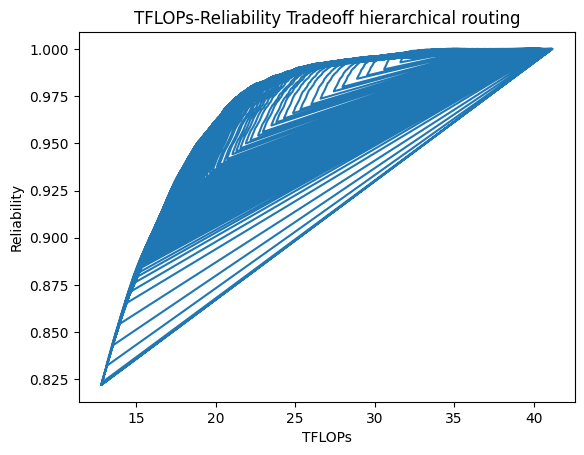

In [25]:
from matplotlib import pyplot as plt
hierarchical_routing_costs = []
hierarchical_routing_reliabilities = []
hierarchical_routing_latencies = []
for comb in hierarchical_routing_tradeoff_results:
    hierarchical_routing_costs.append(hierarchical_routing_tradeoff_results[comb]['flops'])
    hierarchical_routing_reliabilities.append(hierarchical_routing_tradeoff_results[comb]['reliability'])
    hierarchical_routing_latencies.append(hierarchical_routing_tradeoff_results[comb]['average_latency_per_prompt'])
# hierarchical_routing_costs = [cost / max_cost for cost in hierarchical_routing_costs]
hierarchical_routing_costs = [cost / 1e12 for cost in hierarchical_routing_costs]
plt.plot(hierarchical_routing_costs, hierarchical_routing_reliabilities)
plt.title('TFLOPs-Reliability Tradeoff hierarchical routing')
plt.xlabel('TFLOPs')
plt.ylabel('Reliability')
plt.show()

589


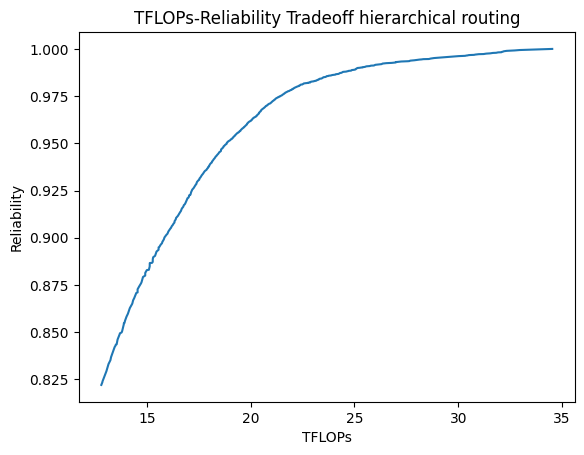

In [26]:
from router_system.compute_flops import get_pareto_front

hierarchical_routing_pareto_front_results = get_pareto_front(hierarchical_routing_costs, hierarchical_routing_reliabilities)
hierarchical_routing_pareto_front_costs = [result[0] for result in hierarchical_routing_pareto_front_results]
hierarchical_routing_pareto_front_reliabilities = [result[1] for result in hierarchical_routing_pareto_front_results]
print(len(hierarchical_routing_pareto_front_costs))
plt.plot(hierarchical_routing_pareto_front_costs, hierarchical_routing_pareto_front_reliabilities)
plt.title('TFLOPs-Reliability Tradeoff hierarchical routing')
plt.xlabel('TFLOPs')
plt.ylabel('Reliability')
plt.show()


Text(0, 0.5, 'Reliability')

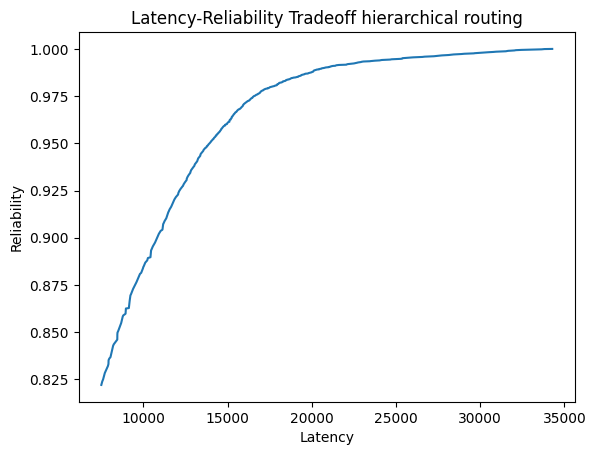

In [27]:
hierarchical_routing_pareto_front_latency_results = get_pareto_front(hierarchical_routing_latencies, hierarchical_routing_reliabilities)
hierarchical_routing_pareto_front_latency_costs = [result[0] for result in hierarchical_routing_pareto_front_latency_results]
hierarchical_routing_pareto_front_latency_reliabilities = [result[1] for result in hierarchical_routing_pareto_front_latency_results]
plt.plot(hierarchical_routing_pareto_front_latency_costs, hierarchical_routing_pareto_front_latency_reliabilities)
plt.title('Latency-Reliability Tradeoff hierarchical routing')
plt.xlabel('Latency')
plt.ylabel('Reliability')

## BERT only routing

Computing FLOPs for different thresholds: 100%|██████████| 101/101 [00:00<00:00, 551.68it/s]


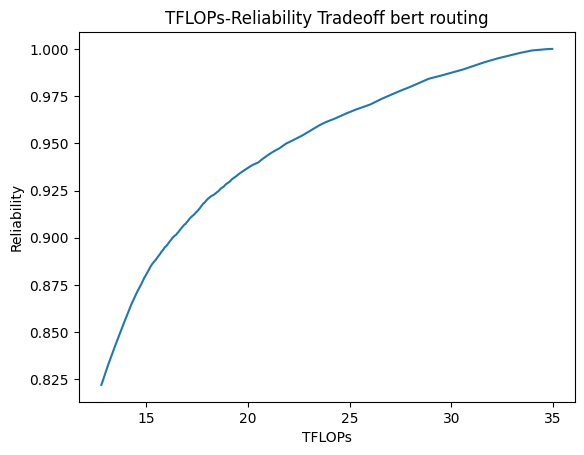

In [28]:
from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_bert_routing


bert_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_bert_routing(file_path, bert_prob_dir, small_model, large_model)
bert_routing_costs = []
bert_routing_reliabilities = []
bert_routing_percantage_to_large_model = []
bert_routing_latencies = []
for comb in bert_routing_tradeoff_results:
    bert_routing_costs.append(bert_routing_tradeoff_results[comb]['flops'])
    bert_routing_reliabilities.append(bert_routing_tradeoff_results[comb]['reliability'])
    bert_routing_percantage_to_large_model.append(bert_routing_tradeoff_results[comb]['sent_to_large_model'] / bert_routing_tradeoff_results[comb]['total_count'])
    bert_routing_latencies.append(bert_routing_tradeoff_results[comb]['average_latency_per_prompt'])
max_cost = max(bert_routing_costs)
# bert_routing_costs = [cost / max_cost for cost in bert_routing_costs]
bert_routing_costs = [cost / 1e12 for cost in bert_routing_costs]
plt.plot(bert_routing_costs, bert_routing_reliabilities)
plt.title('TFLOPs-Reliability Tradeoff bert routing')
plt.xlabel('TFLOPs')
plt.ylabel('Reliability')
plt.show()

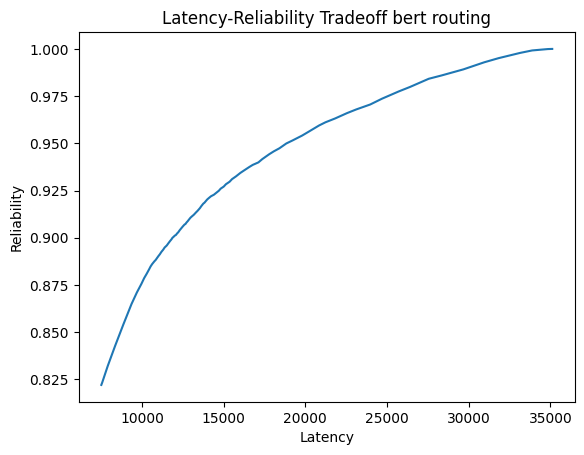

In [29]:
plt.plot(bert_routing_latencies, bert_routing_reliabilities)
plt.title('Latency-Reliability Tradeoff bert routing')
plt.xlabel('Latency')
plt.ylabel('Reliability')
plt.show()


## CPX only Routing TFOPs-Reliability

Computing FLOPs for different thresholds: 100%|██████████| 101/101 [00:00<00:00, 501.22it/s]


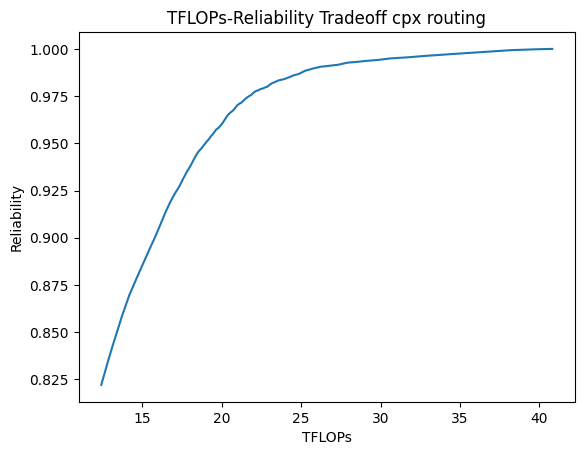

In [30]:
from router_system.compute_flops import reliability_cost_tradeoff_for_different_thresholds_cpx_routing

cpx_routing_tradeoff_results = reliability_cost_tradeoff_for_different_thresholds_cpx_routing(file_path, cpx_prob_dir, small_model, large_model)
cpx_routing_flops = []
cpx_routing_reliabilities = []
cpx_routing_percentage_to_large_model = []
cpx_routing_latencies = []
for comb in cpx_routing_tradeoff_results:
    cpx_routing_flops.append(cpx_routing_tradeoff_results[comb]['flops']/1e12)
    cpx_routing_reliabilities.append(cpx_routing_tradeoff_results[comb]['reliability'])
    cpx_routing_percentage_to_large_model.append((cpx_routing_tradeoff_results[comb]['sent_to_large_model'] / cpx_routing_tradeoff_results[comb]['total_count']) * 100)
    cpx_routing_latencies.append(cpx_routing_tradeoff_results[comb]['average_latency_per_prompt'])

plt.plot(cpx_routing_flops, cpx_routing_reliabilities)
plt.title('TFLOPs-Reliability Tradeoff cpx routing')
plt.xlabel('TFLOPs')
plt.ylabel('Reliability')
plt.show()

## CPX only routing Latency-Reliability

Text(0, 0.5, 'Reliability')

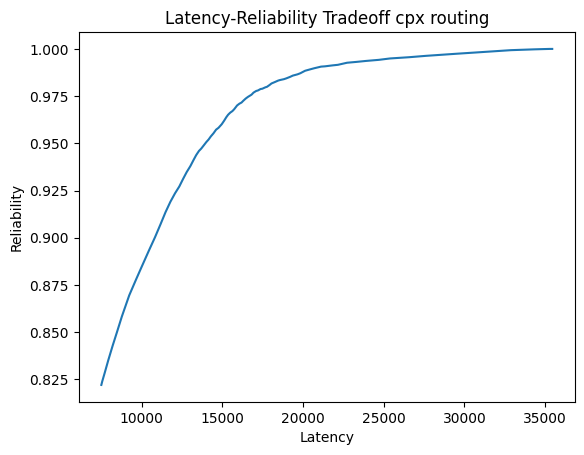

In [31]:
plt.plot(cpx_routing_latencies, cpx_routing_reliabilities)
plt.title('Latency-Reliability Tradeoff cpx routing')
plt.xlabel('Latency')
plt.ylabel('Reliability')

## Plot both bert routing and hierarchical routing TFLOPs-Reliability

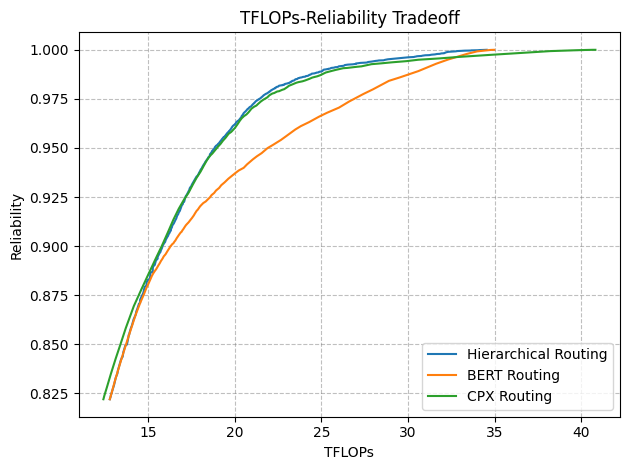

In [32]:
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
# Plot the pareto front for both bert routing and hierarchical routing with legend logarithmic
plt.plot(hierarchical_routing_pareto_front_costs, hierarchical_routing_pareto_front_reliabilities)
plt.plot(bert_routing_costs, bert_routing_reliabilities)
plt.plot(cpx_routing_flops, cpx_routing_reliabilities)
plt.title('TFLOPs-Reliability Tradeoff')
plt.xlabel('TFLOPs')
plt.ylabel('Reliability')
# plt.ylim(0.5, )
plt.legend(['Hierarchical Routing', 'BERT Routing', 'CPX Routing'])
plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5)) 
# Minor ticks appear every 1.0 unit (half of the major step)
# plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.tight_layout()
plt.show()

## Plot both bert routing and hierarchical routing Latency-Reliability

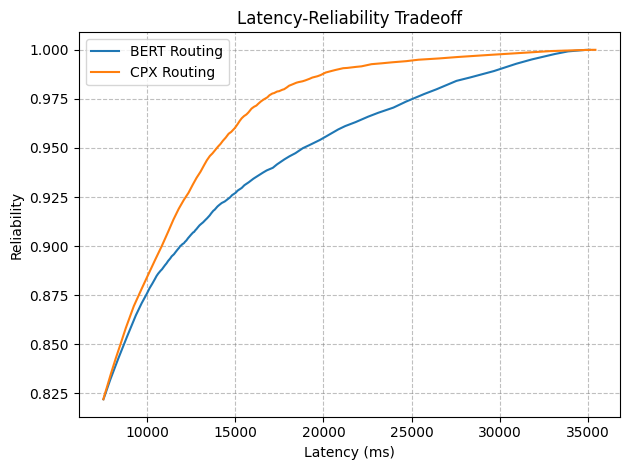

/data/gpfs/projects/punim2662/LLM_routing/LLM_routing/env/lib64/python3.9/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


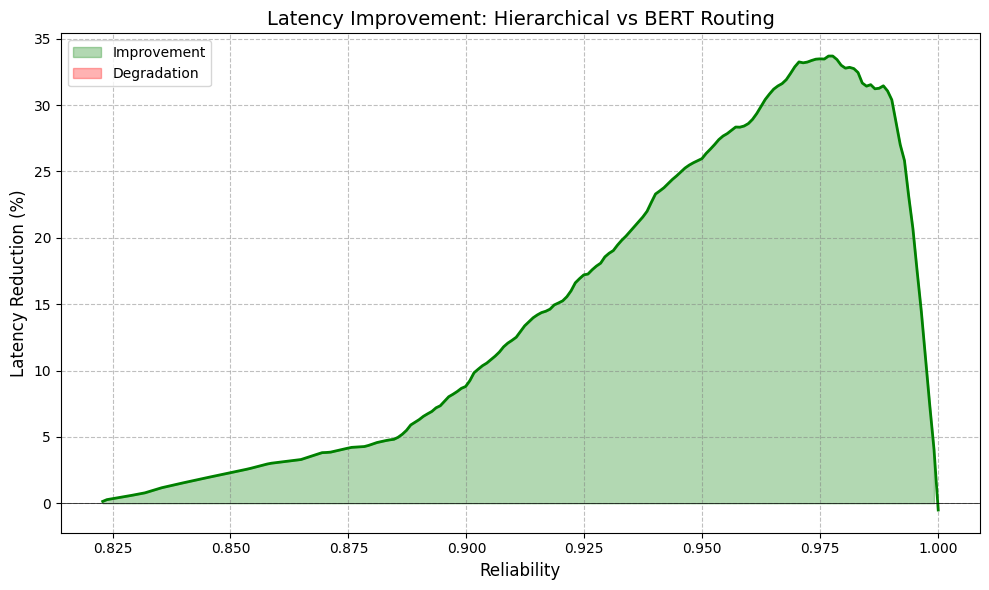

Average improvement: 14.34%
Max improvement: 33.69%
Min improvement: -0.51%


In [36]:
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# # Plot the pareto front for both bert routing and hierarchical routing with legend logarithmic
# plt.plot(hierarchical_routing_pareto_front_latency_costs, hierarchical_routing_pareto_front_latency_reliabilities)
plt.plot(bert_routing_latencies, bert_routing_reliabilities)
plt.plot(cpx_routing_latencies, cpx_routing_reliabilities)
plt.title('Latency-Reliability Tradeoff')
plt.xlabel('Latency (ms)')
plt.ylabel('Reliability')
# plt.ylim(0.5, )
plt.legend(['BERT Routing', 'CPX Routing'])
plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1)) 
# Minor ticks appear every 1.0 unit (half of the major step)
# plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.tight_layout()
plt.show()

# Compute percentage improvement between hierarchical and BERT routing
# First, find the common reliability range
min_reliability = max(
    min(cpx_routing_reliabilities),
    min(bert_routing_reliabilities)
)
max_reliability = min(
    max(cpx_routing_reliabilities),
    max(bert_routing_reliabilities)
)

# Create a common set of reliability values for interpolation
common_reliabilities = np.linspace(min_reliability, max_reliability, 200)

# Interpolate hierarchical routing latencies
# Sort by reliability first to ensure monotonicity for interpolation
hierarchical_sorted = sorted(zip(cpx_routing_reliabilities, 
                                  cpx_routing_latencies))
hierarchical_reliabilities_sorted = [r for r, _ in hierarchical_sorted]
hierarchical_latencies_sorted = [l for _, l in hierarchical_sorted]

bert_sorted = sorted(zip(bert_routing_reliabilities, bert_routing_latencies))
bert_reliabilities_sorted = [r for r, _ in bert_sorted]
bert_latencies_sorted = [l for _, l in bert_sorted]

# Interpolate both curves
hierarchical_interp = interp1d(hierarchical_reliabilities_sorted, hierarchical_latencies_sorted, 
                               kind='linear', bounds_error=False, fill_value='extrapolate')
bert_interp = interp1d(bert_reliabilities_sorted, bert_latencies_sorted, 
                        kind='linear', bounds_error=False, fill_value='extrapolate')

# Get interpolated latencies at common reliability values
hierarchical_latencies_interp = hierarchical_interp(common_reliabilities)
bert_latencies_interp = bert_interp(common_reliabilities)

# Calculate percentage improvement: (bert - hierarchical) / bert * 100
improvement_percentage = ((bert_latencies_interp - hierarchical_latencies_interp) / bert_latencies_interp) * 100

# Filter out any invalid values (where bert_latency is 0 or negative)
valid_mask = (bert_latencies_interp > 0) & np.isfinite(improvement_percentage)
common_reliabilities_clean = common_reliabilities[valid_mask]
improvement_percentage_clean = improvement_percentage[valid_mask]

# Plot the improvement
plt.figure(figsize=(10, 6))
plt.plot(common_reliabilities_clean, improvement_percentage_clean, linewidth=2, color='green')
plt.title('Latency Improvement: Hierarchical vs BERT Routing', fontsize=14)
plt.xlabel('Reliability', fontsize=12)
plt.ylabel('Latency Reduction (%)', fontsize=12)
plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.fill_between(common_reliabilities_clean, 0, improvement_percentage_clean, 
                 where=(improvement_percentage_clean >= 0), alpha=0.3, color='green', label='Improvement')
plt.fill_between(common_reliabilities_clean, 0, improvement_percentage_clean, 
                 where=(improvement_percentage_clean < 0), alpha=0.3, color='red', label='Degradation')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Average improvement: {np.mean(improvement_percentage_clean):.2f}%")
print(f"Max improvement: {np.max(improvement_percentage_clean):.2f}%")
print(f"Min improvement: {np.min(improvement_percentage_clean):.2f}%")

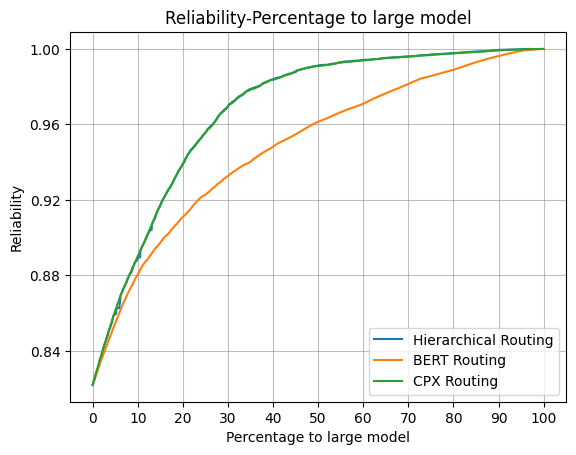

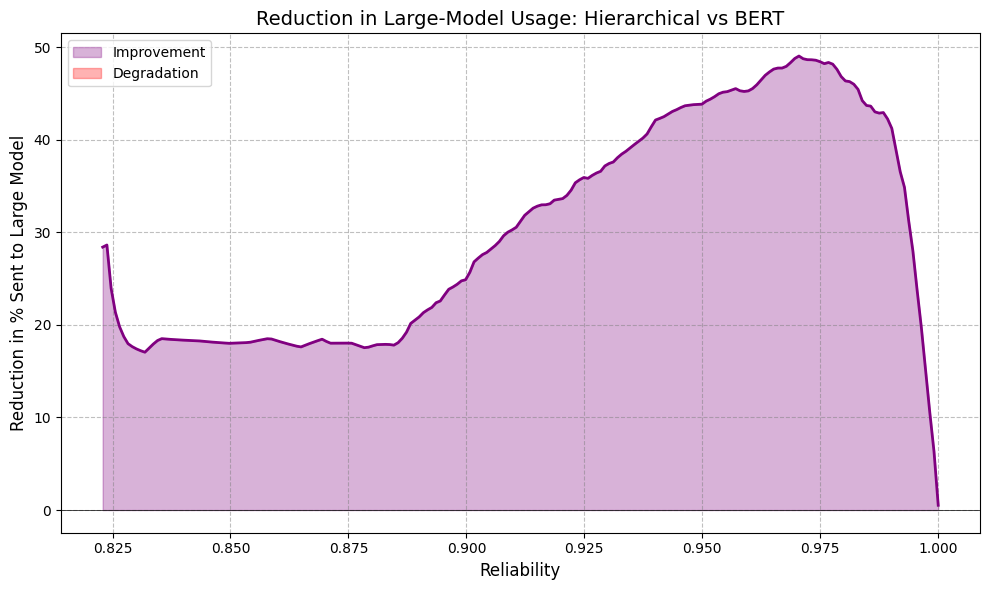

Average reduction in larger-model usage: 30.13%
Max reduction: 49.03%
Min reduction: 0.51%


In [ ]:
hierarchical_routing_percentage_to_large_model = []
for comb in hierarchical_routing_tradeoff_results:
    hierarchical_routing_percentage_to_large_model.append((hierarchical_routing_tradeoff_results[comb]['sent_to_large_model'] / hierarchical_routing_tradeoff_results[comb]['total_count']) * 100)
pareto_front_hierarchical_routing = get_pareto_front(hierarchical_routing_percentage_to_large_model, hierarchical_routing_reliabilities)
pareto_front_hierarchical_routing_percentage_to_large_model = [result[0] for result in pareto_front_hierarchical_routing]
pareto_front_hierarchical_routing_reliabilities = [result[1] for result in pareto_front_hierarchical_routing]

bert_routing_percentage_to_large_model = []
for comb in bert_routing_tradeoff_results:
    bert_routing_percentage_to_large_model.append((bert_routing_tradeoff_results[comb]['sent_to_large_model'] / bert_routing_tradeoff_results[comb]['total_count']) * 100)
# plt.plot(pareto_front_hierarchical_routing_percentage_to_large_model, pareto_front_hierarchical_routing_reliabilities)
plt.plot(bert_routing_percentage_to_large_model, bert_routing_reliabilities)
plt.plot(cpx_routing_percentage_to_large_model, cpx_routing_reliabilities)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.04))
# plt.ylim(0.9, 1)
plt.grid(True, which="both", ls="-", color='gray', alpha=0.5)
plt.title('Reliability-Percentage to large model')
plt.legend(['BERT Routing', 'CPX Routing'], loc='lower right')
plt.xlabel('Percentage to large model')
plt.ylabel('Reliability')
plt.show()

# Compute percentage improvement in routing to the large model
import numpy as np
from scipy.interpolate import interp1d

min_reliability_pct = max(
    min(cpx_routing_reliabilities),
    min(bert_routing_reliabilities)
)
max_reliability_pct = min(
    max(cpx_routing_reliabilities),
    max(bert_routing_reliabilities)
)

common_reliabilities_pct = np.linspace(min_reliability_pct, max_reliability_pct, 200)

hierarchical_pct_sorted = sorted(zip(cpx_routing_reliabilities, 
                                     cpx_routing_percentage_to_large_model))
hierarchical_pct_reliabilities = [r for r, _ in hierarchical_pct_sorted]
hierarchical_pct_values = [p for _, p in hierarchical_pct_sorted]

bert_pct_sorted = sorted(zip(bert_routing_reliabilities, bert_routing_percentage_to_large_model))
bert_pct_reliabilities = [r for r, _ in bert_pct_sorted]
bert_pct_values = [p for _, p in bert_pct_sorted]

hierarchical_pct_interp = interp1d(hierarchical_pct_reliabilities, hierarchical_pct_values, 
                                   kind='linear', bounds_error=False, fill_value='extrapolate')
bert_pct_interp = interp1d(bert_pct_reliabilities, bert_pct_values, 
                           kind='linear', bounds_error=False, fill_value='extrapolate')

hierarchical_pct_common = hierarchical_pct_interp(common_reliabilities_pct)
bert_pct_common = bert_pct_interp(common_reliabilities_pct)

# Improvement: reduction in percentage sent to large model
improvement_pct_large = ((bert_pct_common - hierarchical_pct_common) / bert_pct_common) * 100

valid_mask_pct = (bert_pct_common > 0) & np.isfinite(improvement_pct_large)
common_reliabilities_pct_clean = common_reliabilities_pct[valid_mask_pct]
improvement_pct_large_clean = improvement_pct_large[valid_mask_pct]

plt.figure(figsize=(10, 6))
plt.plot(common_reliabilities_pct_clean, improvement_pct_large_clean, linewidth=2, color='purple')
plt.title('Reduction in Large-Model Usage: Hierarchical vs BERT', fontsize=14)
plt.xlabel('Reliability', fontsize=12)
plt.ylabel('Reduction in % Sent to Large Model', fontsize=12)
plt.grid(True, which="both", ls="--", color='gray', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.fill_between(common_reliabilities_pct_clean, 0, improvement_pct_large_clean, 
                 where=(improvement_pct_large_clean >= 0), alpha=0.3, color='purple', label='Improvement')
plt.fill_between(common_reliabilities_pct_clean, 0, improvement_pct_large_clean, 
                 where=(improvement_pct_large_clean < 0), alpha=0.3, color='red', label='Degradation')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average reduction in larger-model usage: {np.mean(improvement_pct_large_clean):.2f}%")
print(f"Max reduction: {np.max(improvement_pct_large_clean):.2f}%")
print(f"Min reduction: {np.min(improvement_pct_large_clean):.2f}%")

ROC AUC for BERT routing: 0.758644153997682
ROC AUC for CPX routing: 0.8888664328190512
PR AUC for BERT routing: 0.9247394085622868
PR AUC for CPX routing: 0.9704802558693133
PR AUC for BERT routing (neg): 0.4555470790973297
PR AUC for CPX routing (neg): 0.634647713557432
Brier score for BERT routing: 0.1572413647172217
Brier score for CPX routing: 0.16247824383817067


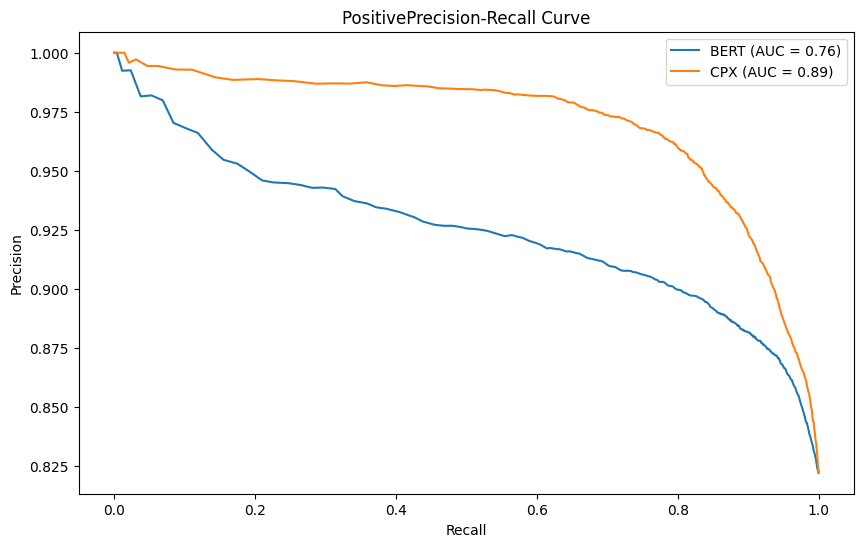

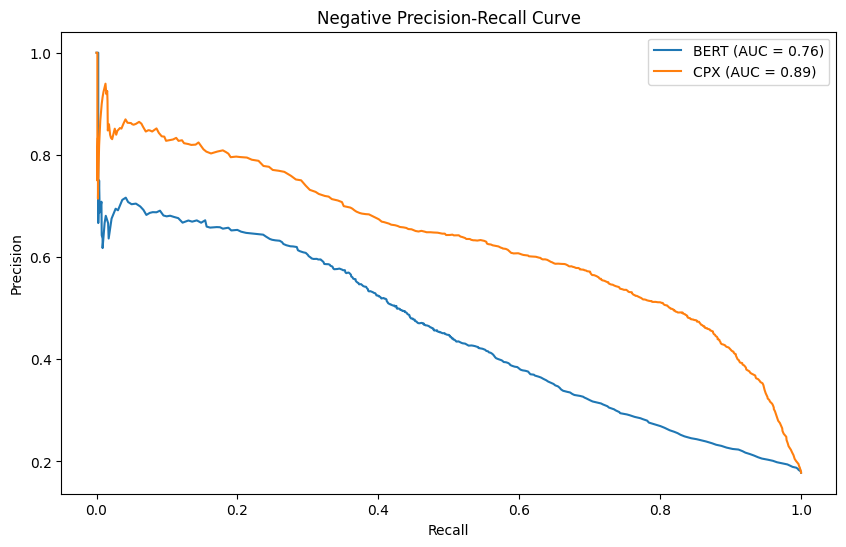

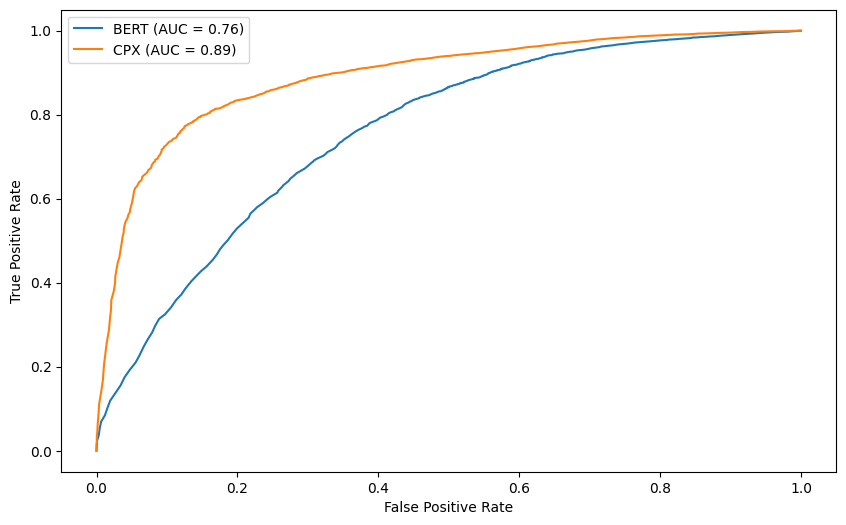

In [35]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_curve, brier_score_loss
import pickle
import numpy as np
# Get ROC curve for BERT routing

with open(bert_prob_dir, 'rb') as f:
    bert_probabilities = pickle.load(f)

fpr_bert, tpr_bert, thresholds_bert = roc_curve(bert_probabilities['labels'], bert_probabilities['probabilities'])
roc_auc_bert = auc(fpr_bert, tpr_bert)

print(f'ROC AUC for BERT routing: {roc_auc_bert}')
# Get ROC curve for CPX routing
with open(cpx_prob_dir, 'rb') as f:
    cpx_probabilities = pickle.load(f)

fpr_cpx, tpr_cpx, thresholds_cpx = roc_curve(cpx_probabilities['labels'], cpx_probabilities['probabilities'])
roc_auc_cpx = auc(fpr_cpx, tpr_cpx)
print(f'ROC AUC for CPX routing: {roc_auc_cpx}')

# GET precision recall curve for all three models
precision_bert, recall_bert, thresholds_bert = precision_recall_curve(bert_probabilities['labels'], bert_probabilities['probabilities'])
precision_cpx, recall_cpx, thresholds_cpx = precision_recall_curve(cpx_probabilities['labels'], cpx_probabilities['probabilities'])

# get precision recall curve for class 0
precision_bert_neg, recall_bert_neg, thresholds_bert_neg = precision_recall_curve(1 - np.array(bert_probabilities['labels']), 1 - np.array(bert_probabilities['probabilities']))
precision_cpx_neg, recall_cpx_neg, thresholds_cpx_neg = precision_recall_curve(1 - np.array(cpx_probabilities['labels']), 1 - np.array(cpx_probabilities['probabilities']))

# print pr_auc for all three models
pr_auc_bert = auc(recall_bert, precision_bert)
pr_auc_cpx = auc(recall_cpx, precision_cpx)
pr_auc_bert_neg = auc(recall_bert_neg, precision_bert_neg)
pr_auc_cpx_neg = auc(recall_cpx_neg, precision_cpx_neg)

print(f'PR AUC for BERT routing: {pr_auc_bert}')
print(f'PR AUC for CPX routing: {pr_auc_cpx}')
print(f'PR AUC for BERT routing (neg): {pr_auc_bert_neg}')
print(f'PR AUC for CPX routing (neg): {pr_auc_cpx_neg}')

# get brier score for all three models
brier_score_bert = brier_score_loss(bert_probabilities['labels'], bert_probabilities['probabilities'])
brier_score_cpx = brier_score_loss(cpx_probabilities['labels'], cpx_probabilities['probabilities'])

print(f'Brier score for BERT routing: {brier_score_bert}')
print(f'Brier score for CPX routing: {brier_score_cpx}')

#plot precision recall curve for all three models
plt.figure(figsize=(10, 6))
plt.plot(recall_bert, precision_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(recall_cpx, precision_cpx, label=f'CPX (AUC = {roc_auc_cpx:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PositivePrecision-Recall Curve')
plt.legend()
plt.show()

#plot negative precision recall curve for all three models
plt.figure(figsize=(10, 6))
plt.plot(recall_bert_neg, precision_bert_neg, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(recall_cpx_neg, precision_cpx_neg, label=f'CPX (AUC = {roc_auc_cpx:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Negative Precision-Recall Curve')
plt.legend()

#plot ROC curve for all three models
plt.figure(figsize=(10, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_cpx, tpr_cpx, label=f'CPX (AUC = {roc_auc_cpx:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()